# Analyzing the Relationship Between Pharmaceutical Companies and Physicians
Samantha Cao, Christina Ferrari, Jennifer Lu, Xixi Zhou

*University of Pennsylvania, Philadelphia, PA 19104*

# Introduction

Throughout this notebook, we investigate the dynamics of the financial relationship between pharmaceutical companies and physicians. Specifically, we explore whether we can predict whether a physician will receive payments for clinical research based on information about the general payments they have received from pharmaceutical companies.






## Before Getting Started

Please note that, to run properly, this notebook requires you to create your own Amazon EMR cluster. If you have AWS Academy and credits remaining, our instructions will walk you through how to set up the cluster. If not, you can still use our instructions as a reference while setting up a cluster on your own.

If you consent to this, this notebook provides an interactive experience. If not, you will find that reading the notebook will provide a sufficient walkthrough of relevant data, code, and findings.

### Import Statements and Other Setup

Some of the cells throughout the rest of the notebook require the following statements to work. If you plan to run cells in the rest of the notebook, run the cell below first. This cell is doing a lot, so it may take about 5 minutes.

In [ ]:
!pip install pyspark
!pip install sparkmagic
!pip install seaborn

%load_ext sparkmagic.magics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib import cm
from pyspark.sql.functions import col, to_date, split, explode, expr
from pyspark.sql.types import *
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics


### Creating an AWS EMR Cluster

Here, we're going to create an AWS EMR cluster.

If you have AWS Academy, you can follow the instructions found [here](https://docs.google.com/document/d/1vIP5HYtAF923wh_hXSag2tfpGnlWwBF5rrz10VAJP50/edit?usp=sharing). If not, these instructions may still be a useful reference while setting up your own cluster, as the process will likely be similar.

Once you have set up the cluster, update the following segments of code to match your EMR cluster:

In [ ]:
# This is your EMRMasterNodeDNS that you copied while setting up your cluster

url = "http://ec2-3-238-142-166.compute-1.amazonaws.com" #update this
username = "cis545-livy" #update this
password = "mcit" #update this

Then, you may run this cell to connect to your cluster.

In [ ]:
%spark add -s spark_session -l python -u {url} -a {username} -p {password}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1682800023481_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


##The Dataset

### Background
As a way of promoting transparency, the Centers for Medicare & Medicaid Services mandates that certain pharmaceutical manufacturers and Group Purchasing Organizations (GPOs) report the payments they make to applicable medical providers. Generally speaking, manufacturers that are required to participate:

1.   Are physically based in the United States or engage in activities within the United States
2.   Produce, prepare, propagate, compound, or convert covered drugs or other medical supplies, and
3.   Have at least one product that is reimbursed by Medicare, Medicaid, or CHIP

Also required to particpate are companies that are commonly owned by a manufacturer fitting the above description and help the entity with regards to a covered product.

Meanwhile, GPOs that are required to participate fit the criteria for (1) and (3) above and purchase, arrange, or negotiate the purchase of a covered product.

Payments made for research are reported separately from payments made for other purposes. In our analysis, we will examine data from both reports.


### Data Source
This data is aggregated and made publicly available in the [Open Payments](https://openpaymentsdata.cms.gov/) section of cms.gov, the official website of the Centers for Medicare & Medicaid.

For this analysis, we have chosen to use CMS Open Payments data from the year [2013](https://www.kaggle.com/datasets/cms/cms-open-payments-dataset-2013), found on Kaggle.com. We chose this data because we trust that our readers will be familiar with accessing data through Kaggle. We will also walk our readers through the process of obtaining this data in the below cells.

### Obtaining the Data
As a reminder, in order to follow along with this notebook, you'll need to have an AWS EMR cluster running. If you are intending to follow along, please make sure you have followed the instructions in **Creating an AWS EMR Cluster** before continuing.

The code below is used to allow our spark session to connect to S3, which is where our data is being stored.

In [ ]:
%%spark

hadoop_conf = spark._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3a.endpoint", "s3.amazonaws.com") #set the S3 endpoint for hadoop to N. Virginia

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 2013 General Payments Data
In the cell below, we'll read in the general payments data and preview the first 5 rows. It may take about a minute.

In [ ]:
%%spark

general_2013_raw_sdf = spark.read.csv("s3a://cms-general-data/2013General.csv", header = True, inferSchema = True)
general_2013_raw_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------------------+---------------------+--------------------+----------------------+--------------------+--------------------+---------------------+-------------------+---------------------+-----------------------------------------------+-----------------------------------------------+--------------+---------------+------------------+-----------------+------------------+---------------------+----------------------+--------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+---------------------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------+---------------------------------+---------------+-----------------------------------

####2013 Research Payments Data
Now we'll read in the research payments data. This should take a bit less time.

In [ ]:
%%spark

research_2013_raw_sdf = spark.read.csv("s3a://cms-general-data/2013Research.csv", header = True, inferSchema = True)
research_2013_raw_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------------------+--------------------------------+---------------------+--------------------+----------------------+--------------------+--------------------+---------------------+-------------------+---------------------+-----------------------------------------------+-----------------------------------------------+--------------+---------------+------------------+-----------------+------------------+---------------------+----------------------+-------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------------+-----------------------------------+------------------------------------+----------------------------------+------------------------------------+------------------------------------------------------+------------------------------------------------------+-----------------------------+------------------------------+---------

#Data Cleaning

#### General Data


##### Filtering

First, because we have knowledge of our dataset, we know that we have two different types of covered recipients: teaching hospitals and physicians. Because we are specifically looking to examine the relationship between pharmaceutical companies and *physicians*, we drop teaching hospitals. We do that using the `Covered_Recipient_Type` column.

Doing this early in the process will save us time on subsequent steps.

In [ ]:
%%spark

general_2013_raw_sdf = general_2013_raw_sdf.filter("Covered_Recipient_Type = 'Covered Recipient Physician'")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#####Dropping Unnecessary Columns
Next, we examine the schema that Spark inferred. This tells us a lot about what columns we have and what types they currently have.

Some of the below columns are unnecessary for our analysis, so they should be dropped. In addition, we having some typing issues. We will also add a few variables and do some one-hot encoding. See the following sections for more details

In [ ]:
%%spark

general_2013_raw_sdf.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Change_Type: string (nullable = true)
 |-- Covered_Recipient_Type: string (nullable = true)
 |-- Teaching_Hospital_CCN: integer (nullable = true)
 |-- Teaching_Hospital_ID: integer (nullable = true)
 |-- Teaching_Hospital_Name: string (nullable = true)
 |-- Physician_Profile_ID: integer (nullable = true)
 |-- Physician_First_Name: string (nullable = true)
 |-- Physician_Middle_Name: string (nullable = true)
 |-- Physician_Last_Name: string (nullable = true)
 |-- Physician_Name_Suffix: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line1: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line2: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Province: string (nullable = true)
 |-- Recipient_Postal_Code: string (nullable = true)
 |-- Physician_Primary

There are several columns that we probably won't need for our model, or even for our exploratory data analysis. For example, if there are multiple types of IDs, we will just pick the most common one. When we have an ID to identify an entity, we will usually drop other identifying information, such as name and street address. We will tend to keep city, state, and zip code information, since those may have explanatory power.

In the below code, we'll drop the things we don't need.

In [ ]:
%%spark

columns_to_drop_for_general = [
    "Change_Type",
    "Teaching_Hospital_ID",
    "Teaching_Hospital_Name",
    "Physician_Middle_Name",
    "Physician_Name_Suffix",
    "Recipient_Primary_Business_Street_Address_Line1",
    "Recipient_Primary_Business_Street_Address_Line2",
    "Contextual_Information",
    "Delay_in_Publication_Indicator",
    "Name_of_Associated_Covered_Drug_or_Biological1",
    "Name_of_Associated_Covered_Drug_or_Biological2",
    "Name_of_Associated_Covered_Drug_or_Biological3",
    "Name_of_Associated_Covered_Drug_or_Biological4",
    "Name_of_Associated_Covered_Drug_or_Biological5"
]

general_2013_raw_sdf = general_2013_raw_sdf.drop(*columns_to_drop_for_general)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### Fixing Data Types
Now we'll fix some typing issues. Things that are IDs should be of type `string`, even when they're numbers. Additionally, `Payment_Publication_Date` should be of type `date`.

In [ ]:
%%spark

from pyspark.sql.functions import col, to_date

general_2013_raw_sdf = general_2013_raw_sdf.withColumn("Teaching_Hospital_CCN", col("Teaching_Hospital_CCN").cast("string"))
general_2013_raw_sdf = general_2013_raw_sdf.withColumn("Physician_Profile_ID", col("Physician_Profile_ID").cast("string"))
general_2013_raw_sdf = general_2013_raw_sdf.withColumn("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID", col("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID").cast("string"))
general_2013_raw_sdf = general_2013_raw_sdf.withColumn("NDC_of_Associated_Covered_Drug_or_Biological4", col("NDC_of_Associated_Covered_Drug_or_Biological4").cast("string"))
general_2013_raw_sdf = general_2013_raw_sdf.withColumn("Record_ID", col("Record_ID").cast("string"))
general_2013_raw_sdf = general_2013_raw_sdf.withColumn("Payment_Publication_Date", to_date(col("Payment_Publication_Date"), "MM/dd/yyyy"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### One-Hot Encoding

Here we create some dummy variables that will be more useful for our analysis than the variables in their current forms. We switch to SQL now that our queries are getting longer.



One thing we are interested in exploring is whether a physician being licensed in more than one state has any explanatory power. Below, we create a dummy variable `Physician_Licensed_in_Multiple_States`, which is 1 if the physician is licensed in 2 or more states. Since the reporting entities fill in state codes in order starting with `Physician_License_State_Code1`, we can just consider all Physicians with a code in `Physician_License_State_Code1` to be licensed in multiple states.

We also create a dummy for `Physician_Owernship_Indicator` . Its values are currently *Yes*, *No*, or *null*.

In [ ]:
%%spark

general_2013_raw_sdf.createOrReplaceTempView("general_2013_raw")

query = '''
  SELECT *,
    /*Multiple States Dummy*/
    CASE
      WHEN Physician_License_State_code2 IS NOT NULL THEN 1
      ELSE 0
    END AS Physician_Licensed_in_Multiple_States,
    /*Ownership Indicator Dummy*/
    CASE
      WHEN Physician_Ownership_Indicator = "Yes" THEN 1
      WHEN Physician_Ownership_Indicator = "No" THEN 0
      ELSE NULL
    END AS Physician_Ownership_Dummy
  FROM general_2013_raw
'''

general_2013_raw_sdf = spark.sql(query)

general_2013_raw_sdf = general_2013_raw_sdf.drop("Physician_Ownership_Indicator")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We also have a very valuable field called `Physician_Specialty` that contains information about the many specialties a physician may have. The field may contain multiple specialties per row, and the specialties are separated by pipes. Below, we split and explode the `Physician_Specialty` column and then use that information to get our dummies.

This code is doing a lot of heavy-lifting, so it may take about a minute.

In [ ]:
%%spark

from pyspark.sql.functions import split, explode, expr

#Split by pipes with or without spaces
general_2013_raw_sdf = general_2013_raw_sdf.withColumn("specialty", split("Physician_Specialty", "\s*\|\s*"))
#If specialty value has a slash, take only the value before the slash
general_2013_raw_sdf = general_2013_raw_sdf.withColumn("specialty", expr("""transform(specialty, x -> regexp_extract(x, '^([^/]+)', 1))"""))

#Get distinct specialties
distinct_specialties = general_2013_raw_sdf.select(explode("specialty").alias("specialty")).distinct()

#One-hot encode specialties
for specialty in distinct_specialties.collect():
  specialty_col = specialty["specialty"]
  general_2013_raw_sdf = general_2013_raw_sdf.withColumn(specialty_col, expr(f"int(array_contains(specialty, '{specialty_col}'))"))

general_2013_raw_sdf = general_2013_raw_sdf.drop("Physician_Specialty", "specialty")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### Verifying the Results

Here we print the schema and show the top 20 rows of the dataset to confirm that our changes have been successful.

In [ ]:
%%spark

general_2013_raw_sdf.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Covered_Recipient_Type: string (nullable = true)
 |-- Teaching_Hospital_CCN: string (nullable = true)
 |-- Physician_Profile_ID: string (nullable = true)
 |-- Physician_First_Name: string (nullable = true)
 |-- Physician_Last_Name: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Province: string (nullable = true)
 |-- Recipient_Postal_Code: string (nullable = true)
 |-- Physician_Primary_Type: string (nullable = true)
 |-- Physician_License_State_code1: string (nullable = true)
 |-- Physician_License_State_code2: string (nullable = true)
 |-- Physician_License_State_code3: string (nullable = true)
 |-- Physician_License_State_code4: string (nullable = true)
 |-- Physician_License_State_code5: string (nullable = true)
 |-- Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name: string (nullabl

In [ ]:
%%spark

general_2013_raw_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+---------------------+--------------------+--------------------+-------------------+----------------+---------------+------------------+-----------------+------------------+---------------------+----------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+---------------------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------+---------------------------------+---------------+-------------------------------------------+------------------------------------+--------------------------------------+--------------+---------------+-----------------+---------------------------------------+-----------------------------------------

With everything looking good, we can promote the dataset to its more official name.

In [ ]:
%%spark

general_2013_sdf = general_2013_raw_sdf.alias("general_2013_sdf")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Research Data

Since the research dataset is very similar, we will follow a similar methodology to that outlined above in general data.

As before, we start by examining the schema, where we notice that many of the columns are the same.

##### Filtering

We start by filtering the data to exclude teaching hospitals.

In [ ]:
%%spark

research_2013_raw_sdf = research_2013_raw_sdf.filter("Covered_Recipient_Type = 'Covered Recipient Physician'")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### Dropping Unnecessary Columns

Again, we drop the columns that provide unnecessary identification information. We also keep only the first principal investigator, since most of the rows do not contain any additional investigators.

In [ ]:
%%spark

research_2013_raw_sdf.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Change_Type: string (nullable = true)
 |-- Covered_Recipient_Type: string (nullable = true)
 |-- Noncovered_Recipient_Entity_Name: string (nullable = true)
 |-- Teaching_Hospital_CCN: integer (nullable = true)
 |-- Teaching_Hospital_ID: integer (nullable = true)
 |-- Teaching_Hospital_Name: string (nullable = true)
 |-- Physician_Profile_ID: integer (nullable = true)
 |-- Physician_First_Name: string (nullable = true)
 |-- Physician_Middle_Name: string (nullable = true)
 |-- Physician_Last_Name: string (nullable = true)
 |-- Physician_Name_Suffix: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line1: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line2: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Province: string (nullable = true)
 |-- Recipi

In [ ]:
%%spark

#Save the schema and iterate over it to avoid writing out all the Principal_Investigator columns
research_schema = research_2013_raw_sdf.schema
unnecessary_investigators = ["Investigator_2", "Investigator_3", "Investigator_4", "Investigator_5"]

investigator_columns = []
for field in research_schema.names:
  if "Principal_Investigator" in field:
    for investigator in unnecessary_investigators:
      if investigator in field:
        investigator_columns.append(field)

#Since we're dropping most of the same columns, we can combine with the columns we dropped for general and then just add a few more
unnecessary_investigator_1_columns = [
    "Principal_Investigator_1_Middle_Name",
    "Principal_Investigator_1_Name_Suffix",
    "Principal_Investigator_1_Business_Street_Address_Line1",
    "Principal_Investigator_1_Business_Street_Address_Line2"
]
columns_to_drop_for_research = columns_to_drop_for_general + investigator_columns + unnecessary_investigator_1_columns
columns_to_drop_for_research.pop(columns_to_drop_for_research.index("Contextual_Information")) #The one column we dropped from general that isn't in research
columns_to_drop_for_research.extend(["Name_of_Study", "Context_of_Research"])

#Drop the columns
research_2013_raw_sdf = research_2013_raw_sdf.drop(
    *columns_to_drop_for_research
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### Fixing Data Types

Again, we'll convert IDs to strings and the `Payment_Publication_Date` to date.

In [ ]:
%%spark

research_2013_raw_sdf = research_2013_raw_sdf.withColumn("Teaching_Hospital_CCN", col("Teaching_Hospital_CCN").cast("string"))
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("Physician_Profile_ID", col("Physician_Profile_ID").cast("string"))
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("Record_ID", col("Record_ID").cast("string"))
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID", col("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID").cast("string"))
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("NDC_of_Associated_Covered_Drug_or_Biological4", col("NDC_of_Associated_Covered_Drug_or_Biological4").cast("string"))
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("Payment_Publication_Date", to_date(col("Payment_Publication_Date"), "MM/dd/yyyy"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

research_2013_raw_sdf.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Covered_Recipient_Type: string (nullable = true)
 |-- Noncovered_Recipient_Entity_Name: string (nullable = true)
 |-- Teaching_Hospital_CCN: string (nullable = true)
 |-- Physician_Profile_ID: string (nullable = true)
 |-- Physician_First_Name: string (nullable = true)
 |-- Physician_Last_Name: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Province: string (nullable = true)
 |-- Recipient_Postal_Code: string (nullable = true)
 |-- Physician_Primary_Type: string (nullable = true)
 |-- Physician_Specialty: string (nullable = true)
 |-- Physician_License_State_code1: string (nullable = true)
 |-- Physician_License_State_code2: string (nullable = true)
 |-- Physician_License_State_code3: string (nullable = true)
 |-- Physician_License_State_code4: string (nullable = true)
 |-- Physician_License_St

##### One-Hot Encoding

Below we add the same dummy variable for whether a physician is licensed in multiple states and whether the principal investigator is licensed in multiple states.

In [ ]:
%%spark

research_2013_raw_sdf.createOrReplaceTempView("research_2013_raw")

query = '''
  SELECT *,
    /*Multiple States Dummy*/
    CASE
      WHEN Physician_License_State_code2 IS NOT NULL THEN 1
      ELSE 0
    END AS Physician_Licensed_in_Multiple_States,
    CASE
      WHEN Principal_Investigator_1_License_State_code2 IS NOT NULL THEN 1
      ELSE 0
    END AS Principal_Investigator_1_Licensed_in_Multiple_States
  FROM research_2013_raw
'''

research_2013_raw_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Again, we one-hot encode the specialties for Physician and for Principal Investigator.

For Physician:

In [ ]:
%%spark

from pyspark.sql.functions import split, explode, expr

#Split by pipes with or without spaces
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("specialty", split("Physician_Specialty", "\s*\|\s*"))
#If specialty value has a slash, take only the value before the slash
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("specialty", expr("""transform(specialty, x -> regexp_extract(x, '^([^/]+)', 1))"""))

#Get distinct specialties
distinct_specialties = research_2013_raw_sdf.select(explode("specialty").alias("specialty")).distinct()

#One-hot encode specialties
for specialty in distinct_specialties.collect():
  specialty_col = specialty["specialty"]
  research_2013_raw_sdf = research_2013_raw_sdf.withColumn(specialty_col, expr(f"int(array_contains(specialty, '{specialty_col}'))"))

research_2013_raw_sdf = research_2013_raw_sdf.drop("Physician_Specialty", "specialty")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For Principal Investigator:

In [ ]:
%%spark

#Split by pipes with or without spaces
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("specialty", split("Principal_Investigator_1_Specialty", "\s*\|\s*"))
#If specialty value has a slash, take only the value before the slash
research_2013_raw_sdf = research_2013_raw_sdf.withColumn("specialty", expr("""transform(specialty, x -> regexp_extract(x, '^([^/]+)', 1))"""))

#Get distinct specialties
distinct_specialties = research_2013_raw_sdf.select(explode("specialty").alias("specialty")).distinct()

#One-hot encode specialties
for specialty in distinct_specialties.collect():
  specialty_col = specialty["specialty"]
  research_2013_raw_sdf = research_2013_raw_sdf.withColumn(specialty_col, expr(f"int(array_contains(specialty, '{specialty_col}'))"))

research_2013_raw_sdf = research_2013_raw_sdf.drop("Principal_Investigator_1_Specialty", "specialty")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### Verifying the Results

Here we show the schema and the first 20 rows of the dataset to confirm we have applied our changes correctly.

In [ ]:
%%spark

research_2013_raw_sdf.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Covered_Recipient_Type: string (nullable = true)
 |-- Noncovered_Recipient_Entity_Name: string (nullable = true)
 |-- Teaching_Hospital_CCN: string (nullable = true)
 |-- Physician_Profile_ID: string (nullable = true)
 |-- Physician_First_Name: string (nullable = true)
 |-- Physician_Last_Name: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Province: string (nullable = true)
 |-- Recipient_Postal_Code: string (nullable = true)
 |-- Physician_Primary_Type: string (nullable = true)
 |-- Physician_License_State_code1: string (nullable = true)
 |-- Physician_License_State_code2: string (nullable = true)
 |-- Physician_License_State_code3: string (nullable = true)
 |-- Physician_License_State_code4: string (nullable = true)
 |-- Physician_License_State_code5: string (nullable = true)
 |-- Principal_

In [ ]:
%%spark

research_2013_raw_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+--------------------------------+---------------------+--------------------+--------------------+-------------------+--------------+---------------+------------------+-----------------+------------------+---------------------+----------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------------+-----------------------------------+----------------------------------+-----------------------------+------------------------------+---------------------------------+--------------------------------+---------------------------------+------------------------------------+-------------------------------------+--------------------------------------------+--------------------------------------------+--------------------------------------------+--------------------------------------------+--------------------------------------------+--------

With everything looking good, we can promote the dataset to its more official name.

In [ ]:
%%spark

research_2013_sdf = research_2013_raw_sdf.alias("research_2013_sdf")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#Exploratory Data Analysis (EDA)
Before going into modeling, it is important to understand the relationships between our variables. Through visualizations, we can gain a preliminary understanding of the factors that may influence the relationship between physicians and pharmaceutical companies.

###Geographic Analysis

####Top 20 Zip Codes - General Physicians
Here, we organize the zip codes in descending order of how many general physicians they have. We then convert the top 20 to a Pandas dataframe for visualization.

In [ ]:
%%spark

general_2013_sdf.createOrReplaceTempView("general_eda_sdf")
query = '''
  SELECT SUBSTR(Recipient_Zip_Code, 1, 5) as Zipcode, COUNT(*) as Count
  FROM general_eda_sdf
  WHERE Recipient_Country LIKE '%United States%'
  GROUP BY SUBSTR(Recipient_Zip_code, 1, 5)
  ORDER BY Count DESC
'''

general_eda_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%spark -o general_eda_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Organize Panda Frame Data
general_eda_sdf['Zipcode'] = general_eda_sdf['Zipcode'].astype(str)
general_eda_sdf = general_eda_sdf.sort_values(by="Count", ascending = False)

#####Bar Plot

We visualize the above using a bar plot.

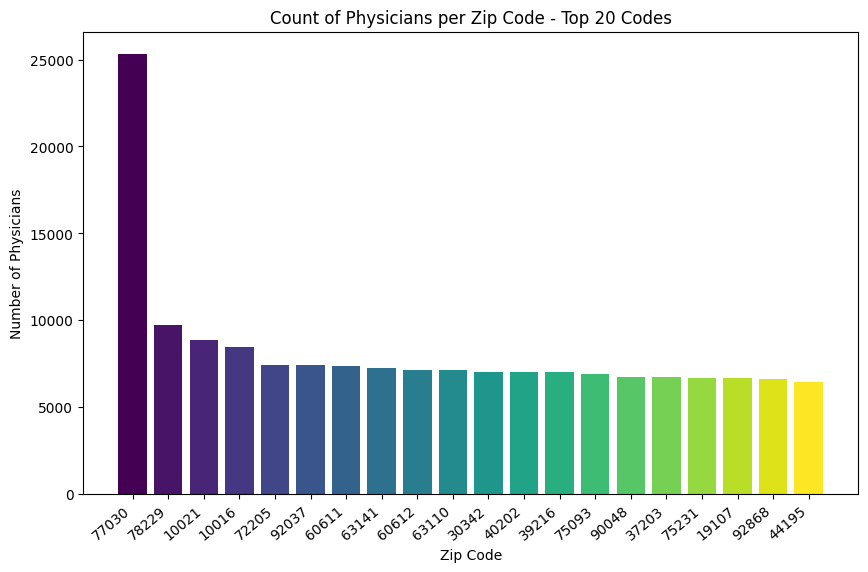

In [ ]:
# Bar plot of count of physicians' residence in top 20 zip codes
import matplotlib.pyplot as plt

top20 = general_eda_sdf.head(20)

plt.figure(figsize = (10,6))
cmap = plt.cm.get_cmap("viridis", 20)

plt.bar(top20["Zipcode"], top20["Count"], color = cmap(np.arange(20)))

plt.xticks(rotation=40, ha="right")
plt.xlabel("Zip Code")
plt.ylabel("Number of Physicians")

plt.title("Count of Physicians per Zip Code - Top 20 Codes")
plt.show()


####Top 20 Zip Codes - Research Providers

As above, we organize zip codes in order of the number of research providers who reside there and choose the top 20.

In [ ]:
%%spark

research_2013_sdf.createOrReplaceTempView("research_eda_sdf")

query = '''
  SELECT SUBSTR(Recipient_Zip_Code, 1, 5) as Zipcode, COUNT(*) as Count
  FROM research_eda_sdf
  WHERE Recipient_Country LIKE '%United States%'
  GROUP BY SUBSTR(Recipient_Zip_Code, 1, 5)
  ORDER BY Count DESC
'''

research_eda_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%spark -o research_eda_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Organize Panda Frame Data
research_eda_sdf['Zipcode'] = research_eda_sdf['Zipcode'].astype(str)
research_eda_sdf = research_eda_sdf.sort_values(by="Count", ascending = False)

#####Bar Plot

Then we plot the above data using a bar plot.

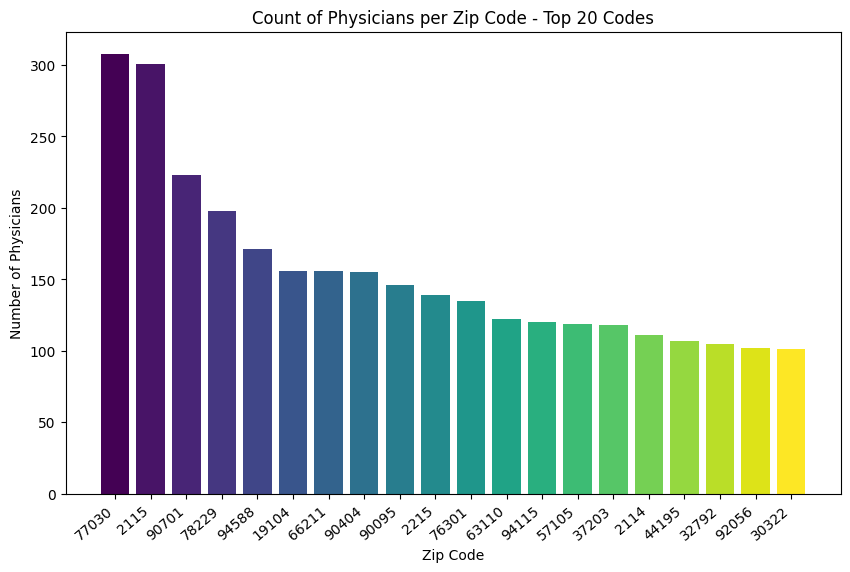

In [ ]:
# Bar Plot of count of physician recipient and the zipcode
import matplotlib.pyplot as plt

top20 = research_eda_sdf.head(20)

plt.figure(figsize = (10,6))
cmap = plt.cm.get_cmap("viridis", 20)

plt.bar(top20["Zipcode"], top20["Count"], color = cmap(np.arange(20)))

plt.xticks(rotation=40, ha="right")
plt.xlabel("Zip Code")
plt.ylabel("Number of Physicians")

plt.title("Count of Physicians per Zip Code - Top 20 Codes")
plt.show()

####Zip Code Map
With visual confirmation of which zip codes are most prevalent, we decide to plot all the zip codes on a map of the United States. \\
We convert the zip code into coordinates of latitude and longitude.
Orange dots represent research data, while blue dots represent general data. The area around each dot is proportionate to the number of physicians who reside there.
Note that the map is user-friendly. If you hover over a dot, you'll see its zip code, latitude, longitude, and provenance (Ex. 99508 at Alaska).


In [ ]:
#Import Libraries for geographical mapping
!pip install pandas_bokeh
!pip install pgeocode
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.9 MB/s eta 0:00:00


In [ ]:
#Convert General Zipcode to Latitude+Longitude
import pandas as pd
import pandas_bokeh
import matplotlib.pyplot as plt
import pgeocode
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
pandas_bokeh.output_notebook()
import plotly.graph_objects as go

nomi = pgeocode.Nominatim('us')

general_eda_sdf['Latitude'] = nomi.query_postal_code(general_eda_sdf['Zipcode'].tolist()).latitude
general_eda_sdf['Longitude'] = nomi.query_postal_code(general_eda_sdf['Zipcode'].tolist()).longitude

general_eda_sdf.head(10)

,Zipcode,Count,Latitude,Longitude
0,77030,25355,29.7041,-95.4010
1,78229,9705,29.5042,-98.5697
2,10021,8872,40.7685,-73.9588
3,10016,8450,40.7443,-73.9781
4,72205,7435,34.7510,-92.3455
5,92037,7431,32.8455,-117.2521
6,60611,7328,41.8971,-87.6223
7,63141,7254,38.6565,-90.4542
8,60612,7127,41.8805,-87.6873
9,63110,7097,38.6185,-90.2564


In [ ]:
#Convert Research Zipcode to Latitude+Longitude
nomi = pgeocode.Nominatim('us')

research_eda_sdf['Latitude'] = nomi.query_postal_code(research_eda_sdf['Zipcode'].tolist()).latitude
research_eda_sdf['Longitude'] = nomi.query_postal_code(research_eda_sdf['Zipcode'].tolist()).longitude

research_eda_sdf.head(10)

,Zipcode,Count,Latitude,Longitude
0,77030,308,29.7041,-95.4010
1,2115,301,NaN,NaN
2,90701,223,33.8654,-118.0731
3,78229,198,29.5042,-98.5697
4,94588,171,37.6873,-121.8957
5,19104,156,39.9597,-75.2024
6,66211,156,38.9667,-94.6169
7,90404,155,34.0268,-118.4733
8,90095,146,33.7866,-118.2987
9,2215,139,NaN,NaN


In [ ]:
#Plot Zipcode Map with Count Density as Trace
fig = go.Figure()
fig.add_trace(go.Scattergeo(
        lon = general_eda_sdf['Longitude'],
        lat = general_eda_sdf['Latitude'],
        text = general_eda_sdf['Zipcode'],
        mode = 'markers',
        name = 'General Residence',
        marker = dict(
                size=general_eda_sdf['Count']/20,
                line_width=0.5,
                sizemode='area',)
        ))

fig.add_trace(go.Scattergeo(
        lon = research_eda_sdf['Longitude'],
        lat = research_eda_sdf['Latitude'],
        text = research_eda_sdf['Zipcode'],
        mode = 'markers',
        name = 'Research Residence',
        marker = dict(
                size=research_eda_sdf['Count']/20,
                line_width=0.5,
                sizemode='area',)
        ))

fig.update_layout(
        title = 'Map Distribution of Physicians and Providers Zipcodes',
        geo_scope='usa',
    )

fig.show()

####Discussion of Geographic Analysis
In the map above, we can see that our top 20 zip codes for each dataframe gave us good intuition. \\
Note that there are many fewer providers in research than physicians in general, which is understandable since usually providers like principal investigators are already physicians. \\
It is worthwhile to note there are some shared zip codes in the top 5 of each dataframe.

##Financial Analysis
Given that money can be a great appeal to loyalty, we seek to determine if companies that spend more garner more loyalty. We do this by finding the average dollars spent by each pharmaceutical company, which we report as a table. Then we create pie charts that show the percentage that each company in the top 25 contributed to all top 25 spending. We then determine if the high-spending companies are the same in both the research and general datasets.

####Top 25 Companies - General Spending
In the below cells, we visualize the top 25 companies of each dataset for in order to compare them and understand the scope of our data.

In [ ]:
#Convert general spark to panda df
%%spark

general_2013_sdf.createOrReplaceTempView("general_eda_sdf")

query = '''
  SELECT Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name, AVG(Total_Amount_of_Payment_USDollars) as Average_Total_Payment 
    FROM general_eda_sdf
      GROUP BY Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name
      ORDER BY Average_Total_Payment DESC
'''

general_eda_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%spark -o general_eda_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#####Table

In [ ]:
general_eda_df.rename(columns = {'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name':'Company', 'Average_Total_Payment':'Average Payment (USD)'}, inplace = True)
general_eda_df['Average Payment (USD)'] = round(general_eda_df['Average Payment (USD)'], 2)

top_general = general_eda_df.sort_values(by="Average Payment (USD)", ascending = False)
top_general = general_eda_df.iloc[0:25] #Top 25 companies

top_general_companies = top_general['Company']
top_general_data = top_general['Average Payment (USD)']

top_general.head(25)


,Company,Average Payment (USD)
0,Nashville Surgical Instruments LLC,688000.00
1,"IDev Technologies, Inc.",474911.84
2,"Calvary Spine, LLC",425000.00
3,Southern Surgical Supply LLC,250000.00
4,Evalve Inc.,234462.20
5,"Southern Surgical Solutions, LLC",200000.00
6,"Ortho Restore, LLC",165828.00
7,"Mid America Management, LLC",121206.11
8,"Mesa Surgical, LLC",110975.19
9,"Millennium Spine, LLC",97500.00


#####Pie Chart

In [ ]:
#Pie Chart of Top 25 Spending Companies
import plotly.express as px

general_fig = px.pie(top_general, values=top_general_data, names=top_general_companies, color_discrete_sequence=px.colors.sequential.RdBu, 
             title = "% of Top 25 General Spending Contributed Per Company", hole = 0.25)

general_fig.show()

####Top 25 Companies - Research Spending

In [ ]:
#Convert research spark to panda df
%%spark

research_2013_sdf.createOrReplaceTempView("research_eda_sdf")

query = '''
  SELECT Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name, AVG(Total_Amount_of_Payment_USDollars) as Average_Total_Payment 
    FROM research_eda_sdf
      GROUP BY Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name
      ORDER BY Average_Total_Payment DESC
'''

research_eda_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%spark -o research_eda_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#####Table

In [ ]:
research_eda_df.rename(columns = {'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name':'Company', 'Average_Total_Payment':'Average Payment (USD)'}, inplace = True)
research_eda_df['Average Payment (USD)'] = round(research_eda_df['Average Payment (USD)'], 2)

top_research = research_eda_df.sort_values(by="Average Payment (USD)", ascending = False)
top_research = research_eda_df.iloc[0:25]

top_research_companies = top_research['Company']
top_research_data = top_research['Average Payment (USD)']

top_research.head(25)


,Company,Average Payment (USD)
0,"Toshiba America Medical Systems, Inc.",66500.00
1,"Therakos, Inc.",62687.50
2,"Intuitive Surgical Operations, Inc.",47214.29
3,"BIOLASE, INC.",45000.00
4,MORTARA INSTRUMENT INC,44511.03
5,"Vital Images, Inc.",33400.00
6,"QOL Medical, LLC",30456.67
7,"BIomet 3i, LLC",29000.00
8,"NIDEK CO., LTD.",27600.00
9,Brahms GmbH,26134.50


#####Pie Chart

In [ ]:
#Pie Chart of Top 25 Research
import plotly.express as px

research_fig = px.pie(top_research, values=top_research_data, names=top_research_companies, color_discrete_sequence=px.colors.sequential.RdBu, 
             title = "% of Top 25 Research Spending Contributed Per Company", hole = 0.25)

research_fig.show()

###Discussion of Financial Analysis
We chose to use Plotly Express over Ploty because it offers better graphics and user-interactive motion. As can be seen above, hovering over a slice shows each company's name and its average payment size. \\
Through this analysis, we have determined that there are no companies in both the top 25 for research spending and general spending.

### Mapping General Payments to Research Payments

In the below cells, we map each Physicians' ID from the general payment dataset to the research dataset to determine how much overlap we have. \\
First, we'll like to check how many same providers are present in both datasets.

In [182]:
%%spark

# Create SQL-accesible table
general_2013_sdf.createOrReplaceTempView("general_2013")
research_2013_sdf.createOrReplaceTempView("research_2013")

# Declare SQL query to be excecuted
query = '''SELECT distinct general_2013.Physician_Profile_ID, Physician_First_Name, Physician_Last_Name, general_2013.Recipient_State  from general_2013 
             join (select Physician_Profile_ID, Principal_Investigator_1_First_Name, Principal_Investigator_1_Last_Name, Recipient_State from research_2013) a 
             on general_2013.Physician_Profile_ID = a. Physician_Profile_ID;'''

general_research_sdf = spark.sql(query)
general_research_sdf.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

7814

We see that there is a small number of physicians that we are interested in, so now we are interested in all the records from the general dataset involving those with research experience, giving us more data to work with:

In [ ]:
%%spark

general_research_sdf.createOrReplaceTempView("general_research")

query = '''select count(*) from general_2013 where Physician_Profile_ID in (select Physician_Profile_ID from general_research)
              ;'''

general_count_sdf = spark.sql(query)
general_count_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|  137400|
+--------+

Now, we label physicians' general records who we known have participated in clinical trial research in preparation of correlation matrix.

In [ ]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
%%spark

# Create SQL-accesible table
# general_2013_sdf.createOrReplaceTempView("general_2013")
general_research_sdf.createOrReplaceTempView("general_research")

# Declare SQL query to be excecuted
query = '''With master as (
              Select a.*,
              b.Physician_Profile_ID as research_physician_id
              From general_2013 a
              Left outer join general_research b On a.Physician_Profile_ID = b.Physician_Profile_ID
              )
              Select *,
              Case when research_physician_id is not null then 1 else 0 end as research_participation_flag
              From master
              ;'''

general_mapped_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

4246661

## Correlation Matrix
Finally, we visualize the correlation between numeric variables.

In [ ]:
%%spark
general_mapped_sdf.createOrReplaceTempView("general_mapped")

# Declare SQL query to be excecuted
query = '''select count(*) from general_mapped where research_participation_flag = 1
              ;'''

research_count_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
general_mapped_short_sdf = general_mapped_sdf.select('Covered_Recipient_Type', 'Teaching_Hospital_CCN', 'Physician_Profile_ID', 'Physician_First_Name', 'Physician_Last_Name', 'Recipient_City', 'Recipient_State', 'Recipient_Zip_Code', 'Recipient_Country', 'Recipient_Province', 'Recipient_Postal_Code', 'Physician_Primary_Type', 'Physician_License_State_code1', 'Physician_License_State_code2', 'Physician_License_State_code3', 'Physician_License_State_code4', 'Physician_License_State_code5', 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Total_Amount_of_Payment_USDollars', 'Date_of_Payment', 'Number_of_Payments_Included_in_Total_Amount', 'Form_of_Payment_or_Transfer_of_Value', 'Nature_of_Payment_or_Transfer_of_Value', 'City_of_Travel', 'State_of_Travel', 'Country_of_Travel', 'Third_Party_Payment_Recipient_Indicator', 'Name_of_Third_Party_Entity_Receiving_Payment_or_Transfer_of_Value', 'Charity_Indicator', 'Third_Party_Equals_Covered_Recipient_Indicator', 'Record_ID', 'Dispute_Status_for_Publication', 'Product_Indicator', 'NDC_of_Associated_Covered_Drug_or_Biological1', 'NDC_of_Associated_Covered_Drug_or_Biological2', 'NDC_of_Associated_Covered_Drug_or_Biological3', 'NDC_of_Associated_Covered_Drug_or_Biological4', 'NDC_of_Associated_Covered_Drug_or_Biological5', 'Name_of_Associated_Covered_Device_or_Medical_Supply1', 'Name_of_Associated_Covered_Device_or_Medical_Supply2', 'Name_of_Associated_Covered_Device_or_Medical_Supply3', 'Name_of_Associated_Covered_Device_or_Medical_Supply4', 'Name_of_Associated_Covered_Device_or_Medical_Supply5', 'Program_Year', 'Payment_Publication_Date', 'Physician_Licensed_in_Multiple_States', 'Physician_Ownership_Dummy', "research_participation_flag")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Select numeric variables to generate the correlation matrix.

In [ ]:
%%spark
from pyspark.sql.functions import col, substring
# select numeric columns to make the correlation metircs
general_corr_sdf = general_mapped_short_sdf.select(
                    'Physician_Profile_ID', 
                    'Recipient_Zip_Code',
                     substring('Recipient_Zip_Code', 1, 5).alias('Recipient_Zip_Code_5'),
                    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID', 
                    'Number_of_Payments_Included_in_Total_Amount', 
                    'Total_Amount_of_Payment_USDollars',
                    'Physician_Licensed_in_Multiple_States',
                    'Physician_Ownership_Dummy',
                    'research_participation_flag')
general_corr_sdf = general_corr_sdf.drop("Recipient_Zip_Code")
general_corr_sdf = general_corr_sdf.drop("Physician_Ownership_Dummy")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We'll create a Pearson correlation matrix using the Statistics library:

In [ ]:
%%spark
features = general_corr_sdf.rdd.map(lambda row: row[0:])

from pyspark.mllib.stat import Statistics

corr_mat=Statistics.corr(features, method="pearson")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Convert to pandas so we can work outside of spark
%spark -o general_corr_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

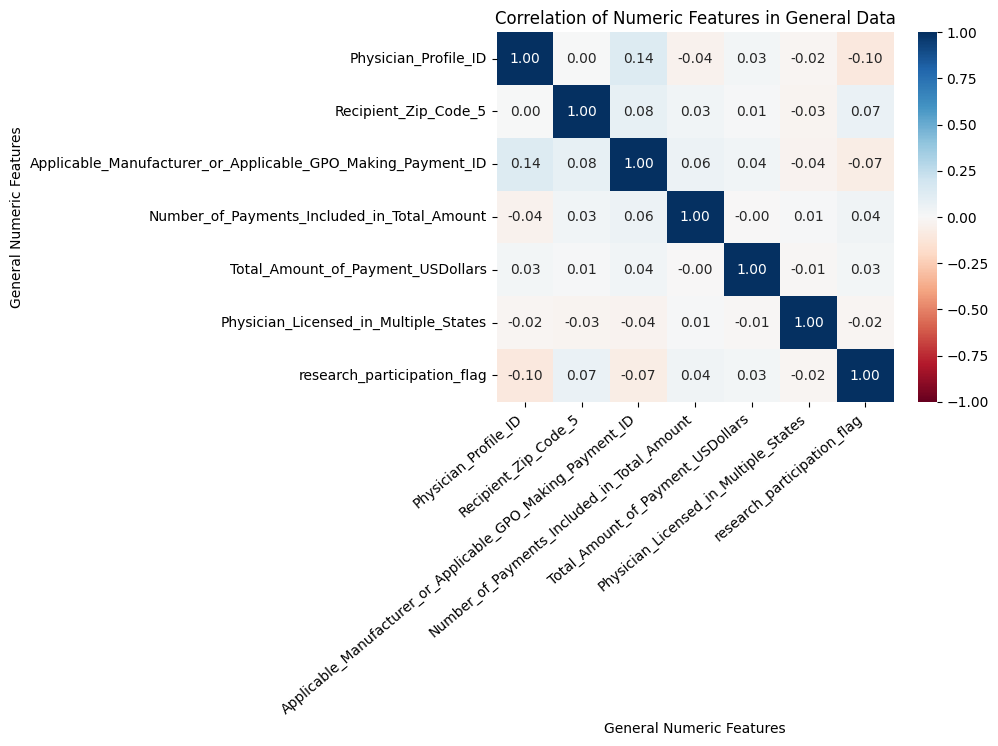

In [ ]:
# Calculate the correlation matrix using Pandas
corr_matrix = general_corr_sdf.corr()

# Create the correlation heatmap using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

#plot
corr_map = sns.heatmap(corr_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt='.2f')
corr_map.set_xlabel("General Numeric Features")
corr_map.set_ylabel("General Numeric Features")
corr_map.set_title("Correlation of Numeric Features in General Data")
corr_map.set_xticklabels(corr_map.get_xticklabels(), rotation = 40, ha = "right")
plt.show()

# PCA

Based on the result of correlation matrix, we suspect that some of the variables may be highly correlated. We use PCA to reduce dimensionality and address multicolinearity.

In [ ]:
%%spark
general_mapped_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+---------------------+--------------------+--------------------+-------------------+------------------+---------------+------------------+-----------------+------------------+---------------------+----------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+---------------------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------+---------------------------------+---------------+-------------------------------------------+------------------------------------+--------------------------------------+--------------+---------------+-----------------+---------------------------------------+---------------------------------------

Below we aggregate the `Total_Amount_of_Payment_USDollars` and prepare the table for PCA.

In [ ]:
%%spark

# Create SQL-accesible table
# general_2013_sdf.createOrReplaceTempView("general_2013")
general_mapped_sdf.createOrReplaceTempView("general_mapped")

# Declare SQL query to be excecuted
query = '''select sum(Total_Amount_of_Payment_USDollars) as Total_Amount_of_Payment_USDollars, Physician_Profile_ID, 
                    Recipient_Zip_Code,
                    Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, 
                    Number_of_Payments_Included_in_Total_Amount, Form_of_Payment_or_Transfer_of_Value, Nature_of_Payment_or_Transfer_of_Value, Product_Indicator, NDC_of_Associated_Covered_Drug_or_Biological1,
                    Physician_Licensed_in_Multiple_States,
                    Physician_Ownership_Dummy,
                    research_participation_flag from general_mapped
                    group by 
                    Physician_Profile_ID, 
                    Recipient_Zip_Code,
                    Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, 
                    Number_of_Payments_Included_in_Total_Amount, Form_of_Payment_or_Transfer_of_Value, Nature_of_Payment_or_Transfer_of_Value, Product_Indicator, NDC_of_Associated_Covered_Drug_or_Biological1,
                    Physician_Licensed_in_Multiple_States,
                    Physician_Ownership_Dummy,
                    research_participation_flag 
              ;'''

general_grouped_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
general_grouped_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------+--------------------+------------------+-----------------------------------------------------------+-------------------------------------------+------------------------------------+--------------------------------------+-----------------+---------------------------------------------+-------------------------------------+-------------------------+---------------------------+
|Total_Amount_of_Payment_USDollars|Physician_Profile_ID|Recipient_Zip_Code|Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID|Number_of_Payments_Included_in_Total_Amount|Form_of_Payment_or_Transfer_of_Value|Nature_of_Payment_or_Transfer_of_Value|Product_Indicator|NDC_of_Associated_Covered_Drug_or_Biological1|Physician_Licensed_in_Multiple_States|Physician_Ownership_Dummy|research_participation_flag|
+---------------------------------+--------------------+------------------+-----------------------------------------------------------+-----------------------------------------

Since PCA only works for numeric columns, we remove five columns that contain non-numeric values.

In [ ]:
%%spark

##have to remove non-numeric columns in order to run PCA
features_sdf = general_grouped_sdf.select("Total_Amount_of_Payment_USDollars", 
                                          "Physician_Ownership_Dummy", 
                                          "Physician_Licensed_in_Multiple_States",
                                          "Number_of_Payments_Included_in_Total_Amount")
      
      
       # "Physician_Profile_ID","Recipient_Zip_Code",
       # "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID",
       # "NDC_of_Associated_Covered_Drug_or_Biological1",
       # "Form_of_Payment_or_Transfer_of_Value",
       # "Nature_of_Payment_or_Transfer_of_Value", "Product_Indicator"

prediction = general_grouped_sdf['research_participation_flag']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Then we use VectorAssembler to process the feature columns into a single vector column.

In [ ]:
%%spark

from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

#run assembler first
feature_column = features_sdf.columns

assembler = VectorAssembler(inputCols = feature_column, outputCol = 'features_vector')

df = assembler.transform(general_grouped_sdf).select('features_vector', 'research_participation_flag')
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------------------+
|     features_vector|research_participation_flag|
+--------------------+---------------------------+
|[121.759999999999...|                          0|
| [36.63,0.0,0.0,1.0]|                          0|
| [13.09,0.0,0.0,1.0]|                          0|
| [12.53,0.0,0.0,1.0]|                          0|
|[1082.67,0.0,0.0,...|                          0|
+--------------------+---------------------------+
only showing top 5 rows

Lastly, before we use PCA, we must normalize our dataset. We do this using StandardScaler.

In [ ]:
%%spark
#run starndard scaler
scaler = StandardScaler(
    inputCol = 'features_vector', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True).fit(df)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df)
df_scaled.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------------------+--------------------+
|     features_vector|research_participation_flag|      scaledFeatures|
+--------------------+---------------------------+--------------------+
|[121.759999999999...|                          0|[-0.0210666863465...|
| [36.63,0.0,0.0,1.0]|                          0|[-0.0288508389684...|
| [13.09,0.0,0.0,1.0]|                          0|[-0.0310032993551...|
| [12.53,0.0,0.0,1.0]|                          0|[-0.0310545048698...|
|[1082.67,0.0,0.0,...|                          0|[0.06679740499546...|
+--------------------+---------------------------+--------------------+
only showing top 5 rows

Now we are ready to apply PCA.

In [ ]:
%%spark 

#run PCA
n_components = 3
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures').fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Explained Variance Ratio [0.26613018 0.25046909 0.24942395]
+--------------------+---------------------------+--------------------+--------------------+
|     features_vector|research_participation_flag|      scaledFeatures|         pcaFeatures|
+--------------------+---------------------------+--------------------+--------------------+
|[121.759999999999...|                          0|[-0.0210666863465...|[0.06215074884768...|
| [36.63,0.0,0.0,1.0]|                          0|[-0.0288508389684...|[0.06365205144420...|
| [13.09,0.0,0.0,1.0]|                          0|[-0.0310032993551...|[0.06406718903521...|
| [12.53,0.0,0.0,1.0]|                          0|[-0.0310545048698...|[0.06407706486575...|
|[1082.67,0.0,0.0,...|                          0|[0.06679740499546...|[0.04520470540787...|
+--------------------+---------------------------+--------------------+--------------------+
only showing top 5 rows

# Modeling

## **Model 1: Linear Regression**

We start with linear regression, since this is most widely-used model in the data science world. It serves as a meaingful base to compare with the results from other models that we run.

In [ ]:
%%spark 

#create new dataset with PCA results and prediction for modeling 
vdf = df_pca.select(['pcaFeatures', 'research_participation_flag'])

#random split
splits = vdf.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark 

from pyspark.ml.regression import LinearRegression

#run the model
lr = LinearRegression(featuresCol = 'pcaFeatures', labelCol='research_participation_flag', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: [0.0,0.0,0.0]
Intercept: 0.024381706093945115

By looking at the R-squared and root mean squared error, we can see that the features have no correlation with the label. This suggests that the general payments dataset does not contain data that will successfully predict whether a physician will engage in a research relationship with a pharmaceutical company. We will verify this observation with two other models.

In [ ]:
%%spark 

#check model results

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

train_df.describe().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE: 0.154235
r2: -0.000000
+-------+---------------------------+
|summary|research_participation_flag|
+-------+---------------------------+
|  count|                    1822503|
|   mean|        0.02438624243691231|
| stddev|        0.15424515120760346|
|    min|                          0|
|    max|                          1|
+-------+---------------------------+

## **Model 2: Decision Tree**

In the below cells, we apply a decision tree to the model. We use this classification model in an attempt to discover which features, if any, are the most valuable for prediction.

In [ ]:
%%spark
#random split the data
train, test = vdf.randomSplit([0.7, 0.3], seed = 2018)

#run the model
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'pcaFeatures', labelCol = 'research_participation_flag', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In evaluating this model, we see that we see that the area under our receiver operating characteristic (ROC) curve is 0.5. ROC values range from 0.5 to 1, with 1 suggesting the most explanatory value of the chosen features. With an ROC of 0.5, this decision tree is no better than a coin flip. The features contribute no explanatory value. The result from this model begins to confirm what we have seen using linear regression -- there is likely no relationship between the information in the general payments dataset and a physician choosing to engage in research.

In [ ]:
%%spark

from pyspark.ml.evaluation import BinaryClassificationEvaluator

#evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="research_participation_flag", rawPredictionCol="rawPrediction", metricName='areaUnderROC')
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Area Under ROC: 0.5

## **Model 3: Random Forest**

Lastly, we use another classification model - random forest, to predict whether a doctor will participate in clinical research.

In [ ]:
%%spark

from pyspark.ml.classification import RandomForestClassifier

#run the model
dt2 = RandomForestClassifier(featuresCol = 'pcaFeatures', labelCol = 'research_participation_flag', maxDepth = 2, numTrees = 20)
dtModel2 = dt2.fit(train)
predictions2 = dtModel2.transform(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The result from random forest is similar to that of the other two models. We see again that the ROC is 0.5, meaning that the model has no explanatory value. We analyze the overall results of our research in the next section.

In [ ]:
%%spark

#evaluate the model
evaluator2 = BinaryClassificationEvaluator(labelCol="research_participation_flag", rawPredictionCol="rawPrediction", metricName='areaUnderROC')
print("Test Area Under ROC: " + str(evaluator2.evaluate(predictions2, {evaluator2.metricName: "areaUnderROC"})))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Area Under ROC: 0.5

# **Comparison and Conclusion**

Our investigation aimed to determine whether the general payment dataset can predict which physicians are more likely to participate in clinical trial research. To achieve this, we compared the research payment dataset with the general payment dataset and identified the physicians who were contributors in both datasets.

To analyze the data, we used Principal Component Analysis (PCA) to reduce the variables to the most representative three dimensions. We then applied Linear Regression, Decision Tree, and Random Forest models. However, the results showed that the predictors were not related to the response variables. Specifically, the Linear Regression model had a low Root Mean Squared Error (RMSE) and a low R-squared value, indicating that the predictions were good, but not related to the predictor. The Decision Tree and Random Forest models also showed a Receiver Operating Characteristic (ROC) value of 0.5, which is the default classification value, indicating that the models' predictive ability was no better than random guessing.

In conclusion, our current analysis suggests that the general payment dataset does not have any predictive power to identify physicians who are more likely to conduct clinical trial research.

# **Challenges and Next Steps**

Due to the nature of the OpenPayment 2013 dataset, we faced several challenges during our analysis. While the dataset is valuable, it is reported by various pharmaceutical companies without any standardized quality control measures. Additionally, 2013 was the first year when OpenPayment was initiated to provide transparency in the pharaceutical processes, thus it lacked normalization, specification, and incomplete research data. As a result, data wrangling and cleansing process were time-consuming.

To address these challenges, we can combine more recent years of the OpenPayment data with a larger dataset to reduce the variance of inconsistent data quality. This will also improve the data structure over time. Furthermore, we can enhance our modeling by adding more columns and trying different models such as logistic regression or applying regularization techniques like Lasso or Ridge to the linear regression model.

In summary, while the OpenPayment dataset presents certain challenges, we can overcome them by using more recent and larger datasets, as well as enhancing our modeling techniques.